# Python 8주차
## 1. 데코레이터
데코레이터는 함수나 클래스에 추가적인 기능을 동적으로 부여하는 Python의 강력한 기능입니다. @을 사용합니다.<br>
정적 메소드와 클래스 메소드를 정의할 때 사용했었습니다.

In [ ]:
class MyClass:
    @classmethod
    def my_class_method(cls):
        print('class method')

    @staticmethod
    def my_static_method():
        print('static method')

데코레이터는 다른 함수를 감싸는 형태로 동작하고, 기존 코드의 수정 없이 동작을 확장하거나 변경할 수 있습니다.<br>
다른 기능들도 그렇듯, 데코레이터도 만들 수 있습니다.

In [1]:
def my_decorator(func):
    def wrapper():
        print('함수를 감쌉니다.')
        func()
        print('함수를 감쌉니다.')
    return wrapper

@my_decorator
def hello():
    print('Hello, World!')

def main():
    hello()

if __name__ == '__main__':
    main()

함수를 감쌉니다.
Hello, World!
함수를 감쌉니다.


데코레이터 내부에서 함수를 호출하기 때문에 위와 같이 동작하게 됩니다.<br>
함수 실행 중 추가적인 작업을 수행하므로, 인증/권한 검사를 하거나, 캐싱을 할 때 자주 사용됩니다.

In [ ]:
class SingletonException(Exception):
    def __init__(self):
        super().__init__('관리자 계정은 1개만 생성할 수 있습니다.')

def operator_command(func):
    def wrapper(self, *args, **kwargs):
        if not self.user.OP:
            raise PermissionError('당신은 해당 명령어에 접근할 권한이 없습니다.')
        return func(self, *args, **kwargs)
    return wrapper

class SuperUser:
    _instance = None

    def __init__(self, name):
        if SuperUser._instance is not None:
            raise SingletonException
        SuperUser._instance = self
        self.name = name
        self.OP = True
        self.money = 0

    @classmethod
    def get_instance(cls, name):
        if cls._instance is None:
            cls._instance = cls(name)
        return cls._instance

class User:
    def __init__(self, name, OP=False):
        self.name = name
        self.OP = OP
        self.money = 0


class Commands:
    def __init__(self, user):
        self.user = user

    @operator_command
    def modify_money(self, value):
        self.user.money = value
        print(f'{self.user.name}님의 돈을 {value}원으로 수정하였습니다.')
        return self.user.money
    
    @operator_command
    def give_OP(self, user):
        user.OP = True
        print(f'{user.name}님에게 관리자의 권한을 부여하였습니다.')
        return user.OP
    
    @operator_command
    def remove_OP(self, user):
        if user == self.user:
            raise PermissionError('자신의 권한을 박탈할 수 없습니다.')
        
        if user == SuperUser.get_instance('super_user'):
            raise PermissionError('최고 관리자의 권한을 박탈할 수 없습니다.')
        
        user.OP = False
        print(f'{user.name}님의 관리자 권한을 박탈하였습니다.')
        return user.OP
    
    def earn_money(self):
        self.user.money += 100
        print(f'100원을 벌었습니다. {self.user.name}님의 현재 돈은 {self.user.money}원입니다.')
        return self.user.money
    

def main():
    super_user = SuperUser.get_instance('super_user')
    user1 = User('user1')
    user2 = User('user2')

    command_sudo = Commands(super_user)
    command_user1 = Commands(user1)
    command_user2 = Commands(user2)

    command_sudo.give_OP(user1)
    command_sudo.give_OP(user2)
    command_sudo.modify_money(100000)
    command_user1.remove_OP(user2)
    command_user2.earn_money()
    command_user2.modify_money(100000)


if __name__ == '__main__':
    try:
        main()

    except SingletonException as exception:
        print(exception)

    except PermissionError as exception:
        print(exception)

    except Exception as exception:
        print(exception)

user1님에게 관리자의 권한을 부여하였습니다.
user2님에게 관리자의 권한을 부여하였습니다.
super_user님의 돈을 100000원으로 수정하였습니다.
user2님의 관리자 권한을 박탈하였습니다.
100원을 벌었습니다. user2님의 현재 돈은 100원입니다.
당신은 해당 명령어에 접근할 권한이 없습니다.


위의 경우 메소드의 name 값도 받으므로, 가변 매개변수를 통해 다양한 값을 받을 수 있도록 하였습니다.<br>
*args는 위치 가변 매개변수로, 리스트, 튜플을 받고, **kwargs는 키워드 가변 매개변수로 딕셔너리를 받습니다. <br>
<br>
다음은 피보나치 수열의 메모이제이션을 사용한 함수이며, 부가적으로<br>
<br>
함수의 실행 시간을 측정해서 출력해주는 데코레이터<br>
함수를 실행하기 전에 사용자에게 진행 여부를 확인하는 데코레이터<br>
<br>
를 추가로 구현하였습니다.

In [5]:
def memo(func):
    cache = {}
    def wrapper(n):
        if n not in cache:
            cache[n] = func(n)
        return cache[n]
    return wrapper

def running_time(func):
    import time
    
    def wrapper(*args, **kwargs):
        if not hasattr(wrapper, "_is_running"):
            wrapper._is_running = True  # 실행 중 플래그 설정
            start = time.time()
            result = func(*args, **kwargs)
            end = time.time()
            print(f'{func.__name__} 함수 실행 시간: {end - start:.6f}초')
            wrapper._is_running = False  # 실행 완료 플래그 해제
            return result
        else:
            # 내부 재귀 호출에서는 단순히 함수 실행
            return func(*args, **kwargs)
    return wrapper

def ask_run(func):
    def wrapper(*args, **kwargs):
        if hasattr(wrapper, "_is_running") and wrapper._is_running:
            return func(*args, **kwargs)
        
        response = input('함수를 실행할까요? (yes/no): ')
        if response == 'yes':
            wrapper._is_running = True
            result = func(*args, **kwargs)
            wrapper._is_running = False 
            return result
    return wrapper

@ask_run
@running_time
@memo
def fib(n):
    if n < 2:
        return n
    return fib(n-1) + fib(n-2)

def main():
    print(fib(500))

if __name__ == '__main__':
    main()

wrapper 함수 실행 시간: 0.017034초
139423224561697880139724382870407283950070256587697307264108962948325571622863290691557658876222521294125


hasattr()는 Python의 내장 함수로, 객체 내에 속성을 가지고 있는지의 여부를 확인합니다. 객체에 속성이 존재하면 True를 아니면 False를 반환합니다. <br>
running_time과 ask_run은 재귀 함수와 같이 함수를 반복할 경우, 그 실행 시간을 여러번 물어볼 수 있습니다. 반복이 몇 번동안만 된다면 큰 문제가 없을 수 있지만, <br>
위와 같이 순환하는 함수는 메모이제이션을 한다고 하더라도 시간 복잡도는 O(n)으로 최소 500번의 응답에 입력을 해야합니다.<br>
이를 막기 위해 wrapper() 함수에 몇 가지 조건을 추가하였습니다. 두 작업 모두 비슷한 원리이므로, ask_run 부분만 설명합니다.<br>
wrapper() 함수는 기본적으로 함수와 그 함수의 매개변수들을 모두 가변매개변수를 통해 받습니다.<br>
_is_running은 wrapper() 함수 내의 플래그로 프로그램의 흐름을 제어하는데 사용됩니다.<br>
처음 함수를 실행할 때는, is_running이 존재하지 않으므로, hasattr() 함수는 False를 반환합니다.<br>
이후, wrapper()가 본격적으로 동작하기 시작하므로, _is_running을 True로 바꾸고, func(fib)을 실행합니다.<br>
fib()은 또다른 fib()를 호출하는데, 이미 is_running이 존재하고, 이는 True이므로, 첫 조건문이 실행됩니다.<br>
이 작업이 계속 반복되고 반복이 종료된 이후, is_running은 False가 됩니다.<br>
이 작업을 통해 첫 번째 실행에만 실행 여부를 묻고, 두 번째부터는 묻지 않을 수 있게 됩니다.

## 2. 이터레이터와 제너레이터
이터레이터는 반복을 수행하기 위한 객체로 한 번에 하나씩 데이터를 반환합니다. <br>
이터레이터는 이터러블로, 반복 가능하지만 그 역은 성립하지 않습니다.

In [1]:
my_list = [1, 2, 3]
my_iterator = iter(my_list)
print(f"my_list는 반복 가능한 객체인가요? {hasattr(my_list, "__iter__")}")
print(f"my_list의 다음 값을 반환하는 속성을 가지고 있나요? {hasattr(my_list, "__next__")}")
print(f"my_iterator는 반복 가능한 객체인가요? {hasattr(my_iterator, "__iter__")}")
print(f"my_iterator의 다음 값을 반환하는 속성을 가지고 있나요? {hasattr(my_iterator, "__next__")}")

my_list는 반복 가능한 객체인가요? True
my_list의 다음 값을 반환하는 속성을 가지고 있나요? False
my_iterator는 반복 가능한 객체인가요? True
my_iterator의 다음 값을 반환하는 속성을 가지고 있나요? True


리스트, 튜플, 딕셔너리와 같이 여러 번 반복할 수 있는 객체로, 실행 중 원할 때마다 반복할 수 있습니다. <br>
그런 한편 이터레이터는 한 번만 반복할 수 있는 객체로, 한 번 호출시 한 번만 반복할 수 있습니다.<br>

In [15]:
my_list = [1, 2, 3, 4, 5, 6]
my_iterator = iter(my_list)

for i in range(3):
    print(f"{i+1}번째 순회: 이터레이터")
    if i == 2:
        my_iterator = iter(my_list)
    for mi in my_iterator:
        print(mi, end=' ')
    print()

    print(f"{i+1}번째 순회: 리스트")
    for ml in my_list:
        print(ml, end=' ')
    print()
    print()

1번째 순회: 이터레이터
1 2 3 4 5 6 
1번째 순회: 리스트
1 2 3 4 5 6 

2번째 순회: 이터레이터

2번째 순회: 리스트
1 2 3 4 5 6 

3번째 순회: 이터레이터
1 2 3 4 5 6 
3번째 순회: 리스트
1 2 3 4 5 6 



이와 같이 이터레이터 객체는 한 번 사용되면 다시 호출하지 않는 이상 더 이상 사용되지 않습니다. <br>
이터레이터는 대량의 데이터를 효율적으로 처리하는 등의 메모리 관리를 할 때 유용하게 사용됩니다. <br>
또한 값을 하나씩 반환하므로 다음과 같이 반복문을 사용하지 않더라도 사용할 수 있습니다.

In [20]:
def main():
    my_list = [1, 2, 3, 4, 5, 6]
    my_iterator = iter(my_list)


    for i in range(7):
        print(next(my_iterator), end=' ')

if __name__ == '__main__':
    try:
        main()
    except StopIteration:
        print('\n반복을 종료합니다.')

1 2 3 4 5 6 
반복을 종료합니다.


만약 이터레이터를 직접 출력할 경우, 이터레이터의 메모리 주소(str)를 출력합니다. 값을 반환받기 위해서는 next() 메소드를 이용합니다.<br>
이는 이터레이터의 다음 값을 반환하는 메소드입니다.<br>
for 루프는 내부적으로 iter()과 next()를 자동으로 호출하기 때문에, 이와 같은 작업을 하지 않아도 됩니다.<br>
또한, StopIteration 예외를 for은 자동으로 감지하여 반복을 종료하는 기능을 가집니다.

### 제너레이터
제너레이터는 이터레이터를 쉽게 생성하기 위한 함수입니다.<br>
이는 데이터를 한 번에 하나씩 생성하여 메모리 효율적으로 동작합니다.<br>
제너레이터는 이터레이터의 한 종류로, 호출 이후의 상태를 기억하여 다음 호출시 중단된 지점부터 실행합니다. 마찬가지로, 한 번만 반복 가능하므로,<br>
반복 종료 후 StopIteration 예외를 실행합니다.

In [21]:
def my_generator():
    yield 1
    yield 2
    yield 3

def main():
    gener = my_generator()
    print(next(gener))
    print(next(gener))
    print(next(gener))
    print(next(gener))

if __name__ == '__main__':
    try:
        main()
    except StopIteration:
        print('반복을 종료합니다.')

1
2
3
반복을 종료합니다.


다음과 같이 할 경우 제너레이터를 반복적으로 사용할 수 있습니다.

In [25]:
def iterable_generator():
    a = 0
    while True:
        yield a
        a += 1


def main():
    gen = iterable_generator()
    for gens in gen:
        print(gens, end=' ')
        if gens > 100:
            break

if __name__ == '__main__':
    main()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 

## 3. 어노테이션
Python에서 함수, 변수, 클래스에 대한 타입 힌트를 주거나 추가 정보를 제공하기 위해 주석을 사용합니다. <br>
뿐만 아니라 우리는 어노테이션을 사용할 수 있습니다. 이는 타입에 대한 힌트를 제공하여 코드의 유지보수성을 높일 수 있습니다.

In [ ]:
from typing import Optional, Union


class Node:
    def __init__(self, data: Union[int, float]):
        self.data: int = data  # 노드의 데이터 (정수 타입)
        self.next: Optional[Node] = None  # 다음 노드를 가리키는 포인터 (초기값 None)


class LinkedList:
    def __init__(self):
        self.head: Optional[Node] = None  # 리스트의 시작 노드 (초기값 None)

    def append(self, data: Union[int, float]) -> None:
        new_node = Node(data)  # 새 노드 생성
        
        # 리스트가 비어 있는 경우
        if not self.head:
            self.head = new_node
            return
        
        # 마지막 노드로 이동
        current: Node = self.head
        while current.next:
            current = current.next
        
        # 마지막 노드에 새 노드 연결
        current.next = new_node

    def display(self) -> None:
        current = self.head
        while current:
            print(current.data, end=" -> ")
            current = current.next
        print("None")

이 코드는 단순 연결 리스트를 구현한 것입니다. 어노테이션 사용시 위와 같이 Optional, Union을 사용하면 더 많은 힌트를 제공할 수 있습니다.<br>
Optional은 Node를 반환할 수도, 아예 반환하지 않을 수 있을 수도 있다는 것을 알려주는 것이고, Union은 두 개 이상의 값을 입력 및 반환할 수 있음을 알려줍니다.

# 과제: 서울 지하철 길 찾기 알고리즘
서울 지하철은 복잡하며, 최적의 길을 찾기 위해 네비게이션을 이용하는 경우가 있습니다.<br>
이번에는 서울 지하철의 출발역과 도착역을 입력하면, 최선의 경로를 알려주는 알고리즘을 설계합니다. <br>
전제 조건은 다음과 같습니다.<br>

```markdown
- 각 역의 간격은 고려하지 않는다. (고려한다고 하더라도 거의 의미가 없음)
- 최적의 경로는 '최소 환승', '최단 거리' 두 개를 알려주고, 경로가 두 개 이상인 경우 임의로 지정된 하나의 경로만 알려준다.
- 비용은 고려하지 않는다.
```

코드를 구현하기 위해 사용하거나 바탕이 된 알고리즘에 대해 설명합니다.

## 1. 이중 연결 리스트
연결 리스트는 데이터를 순차적으로 구현하기 위해 사용하는 동적인 자료구조입니다. Python의 경우 이미 리스트, 튜플, 딕셔너리는 동적이어서<br> 
이 의미가 많이 상쇄되지만, C와 같이 정적인 배열을 대체하기 위해 사용됩니다.<br>
연결 리스트는 크게, 단순 연결 리스트, 이중 연결 리스트, 원형 연결 리스트로 나뉩니다.<br>
세 연결 리스트는 공통적으로, 데이터와 그 이웃한 값을 가리키는 정보가 있습니다. <br>
<br>
비유하며 설명하자면, 학생 30명이 있는 반에서 출석번호대로 나열한다고 해볼 때 우리는 이 30명의 순서와 이름을 항상 외울 필요가 없습니다. <br>
과장되어 설명하면, 1번 학생만 알아도 모든 학생을 알 수 있습니다. <br>
<br>
학생들에게 자신의 바로 뒷번호가 누군지만 외우게 한다면, 우리는 15번 학생이 누군지를 1번 학생에게 물어보더라도 알 수 있습니다. <br>
1번 학생은 2번 학생이 누군지 알고 있으므로, 2번 학생에게 15번을 요청하면 되고, 2번도 마찬가지로 3번을, 3번은 4번을 이렇게 반복하여 15번 학생이 누군지를 알 수 있습니다.<br>
또한, 만약 15번 학생이 전학을 가서 이제 없다고 하더라도, 14번 학생에게 16번 학생을 외우라고 하면 우리는 학생을 찾는데 아무런 문제가 없습니다. <br>
추가로 만약에 18번과 19번 학생 사이에 학생 1명을 추가(18.5번)하고 싶다면, 18번 학생에게 18.5번 학생이 누군지를 알게 하고,<br>
18.5번 학생에게 19번 학생이 누군지 알게 하면 됩니다.<br>
이는 단순 연결 리스트를 비유한 것입니다. 학생은 노드고, 그 다음 학생이 누군지 알게 하는 것은 다음 노드가 무엇인지를 명시하는 것으로 비유할 수 있습니다.<br>
노드의 추가 및 삭제도 위와 동일하게 진행됩니다.<br>
이중 연결 리스트는, 자신의 앞 노드가 무엇인지도 알게 하는 것으로, 13번 학생이 12번과 14번 학생이 누군지를 알게 하는 것과 같습니다. <br>
또한 원형 연결 리스트는 마지막 노드가 첫 번째 노드가 무엇인지를 알게 하는것으로, 30번 학생이 1번 학생이 누군지를 알게 하는 것과 같습니다.<br>
Python은 기본적으로 이중 연결 리스트를 지원하는 모듈이 존재하지 않기 때문에 다음과 같이 직접 구현하였습니다.

In [5]:
from typing import Optional, Union

class Node:
    def __init__(self, data: Union[int, float]):
        self.data: Union[int, float] = data
        self.prev: Optional[Node] = None
        self.next: Optional[Node] = None

class DoubleLinkedList:
    def __init__(self):
        self.head: Optional[Node] = None # 첫 번째 노드를 가리키는 포인터, 가상의 노드
        self.tail: Optional[Node] = None # 마지막 노드를 가리키는 포인터, 가상의 노드

    # 노드 추가
    def append(self,data: Union[int, float]) -> None:
        new_node = Node(data)
        if not self.head:
            self.head = new_node
            self.tail = new_node
            return
        
        self.tail.next = new_node
        new_node.prev = self.tail
        self.tail = new_node
        return
    
    # 특정 값인 노드 삭제
    def delete(self, data: Union[int, float]) -> None:
        current: Optional[Node] = self.head

        while current:  
            if current.data == data:
                if current == self.head:  
                    self.head = current.next
                    if self.head:  
                        self.head.prev = None

                elif current == self.tail:  
                    self.tail = current.prev
                    if self.tail:  
                        self.tail.next = None

                else:  
                    current.prev.next = current.next
                    current.next.prev = current.prev
                del current  
                return  
            current = current.next

    # 리스트를 문자열로 반환
    def __str__(self) -> str:
        result = ""
        current: Optional[Node] = self.head
        while current:
            result += str(current.data)
            if current.next:  # 다음 노드가 존재하면 화살표 추가
                result += " -> "
            current = current.next
        return result
    

def main():
    linked_list = DoubleLinkedList()
    for i in range(10):
        linked_list.append(i + 1)

    linked_list.delete(3)
    print(linked_list)

if __name__ == '__main__':
    main()

1 -> 2 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10


## 2. 트리 구조와 그래프 구조

### 트리
트리 구조란 그래프의 일종으로, 한 노드에서 시작해서 다른 정점들을 순회하여 자기 자신에게 돌아오는 순환이 없는 연결 그래프입니다. <br>
트리 구조는 크게 부모 노드와 자식 노드가 존재하며, 디렉토리의 형태와 비슷한 구조로 루트 노드를 제외한 모든 노드는 하나의 부모 노드를 가집니다.

In [6]:
class Tree:
    def __init__(self, data):
        self.data = data
        self.children = []
    
    def add_child(self, data):
        self.children.append(Tree(data))
    
    def remove_child(self, data):
        self.children = [child for child in self.children if child.data != data]
    
    def traverse(self):
        print(self.data)
        for child in self.children:
            child.traverse()


def main():
    root = Tree('root')
    root.add_child('child1')
    root.add_child('child2')
    root.add_child('child3')
    root.traverse()

if __name__ == '__main__':
    main() 

root
child1
child2
child3


그러나, 지하철 역 알고리즘에 사용하기에 지하철 역 간에는 상위와 하위 개념이 없기 때문에, 트리를 사용하기에는 부적합합니다.

### 그래프
그래프는 트리와 비슷한 구조로, 노드와 간선으로 이루어진 자료구조입니다. 트리와 달리 상위와 하위의 개념이 없으며, 가중치라는 개념이 존재합니다.

In [1]:
class Graph:
    def __init__(self):
        # 인접 리스트로 그래프를 표현
        self.graph = {}

    def add_node(self, node):
        # 노드 추가 (기본적으로 빈 리스트)
        if node not in self.graph:
            self.graph[node] = []

    def add_edge(self, node1, node2, weight=1):
        # 양방향 간선 추가
        if node1 not in self.graph:
            self.add_node(node1)
        if node2 not in self.graph:
            self.add_node(node2)
        self.graph[node1].append((node2, weight))
        self.graph[node2].append((node1, weight))

    def display(self):
        # 그래프 내용 출력
        for node, edges in self.graph.items():
            print(f"{node} -> {edges}")

def main():
    # 그래프 생성
    g = Graph()

    # 노드와 간선 추가
    g.add_edge("A", "B", 4)
    g.add_edge("B", "C", 2)
    g.add_edge("C", "A", 5)
    g.add_edge("A", "D", 3)

    # 그래프 출력
    g.display()
    return 0

if __name__ == '__main__':
    main()

A -> [('B', 4), ('C', 5), ('D', 3)]
B -> [('A', 4), ('C', 2)]
C -> [('B', 2), ('A', 5)]
D -> [('A', 3)]


또한, NetworkX라는 모듈을 통해서 그래프를 구현할 수 있습니다. 직접 만든 것보다 빠르고 더 많은 기능을 제공합니다.<br>
기본 제공 모듈이 아니기 때문에 따로 설치를 해야 합니다.

Matplotlib is building the font cache; this may take a moment.


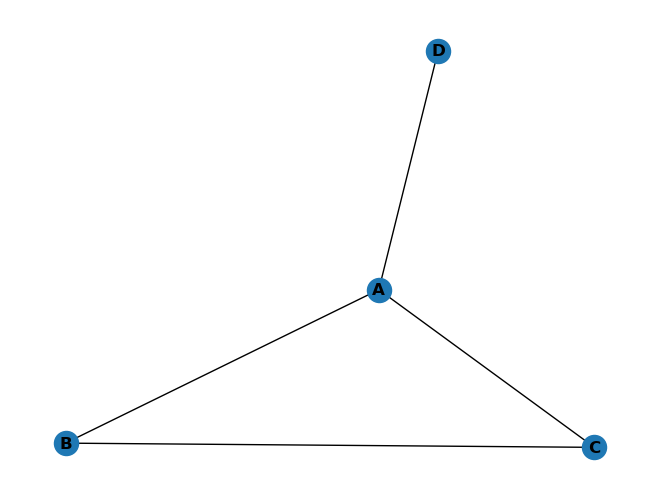

In [2]:
import networkx as nx

def main():
    G = nx.Graph()
    G.add_edge('A', 'B', weight=4)
    G.add_edge('B', 'C', weight=2)
    G.add_edge('C', 'A', weight=5)
    G.add_edge('A', 'D', weight=3)

    nx.draw(G, with_labels=True, font_weight='bold')
    return 0

if __name__ == '__main__':
    main()

각 역은 서로 상위와 하위 개념이 없으며, 서로가 얽혀있고 상황에 따라 가중치도 고려될 수 있으므로 역을 표현하는 것에는 그래프가 가장 적절합니다.<br>
<br>

## 3. BFS와 DFS
BFS와 DFS는 탐색 알고리즘으로, 각각 너비 우선 탐색과 깊이 우선 탐색을 의미합니다.<br>
BFS는 시작 노드와 가까운 노드부터 우선적으로 탐색합니다.<br>
DFS는 시작 노드에서 인접한 한 노드에 접근 후 그 노드에서 최대한 깊이 내려간 후 다시 올라와 다른 노드를 탐색합니다.

In [1]:
from collections import deque

def bfs(graph, start, visited):
    queue = deque([start])
    visited[start] = True
    print("BFS:", end=" ")

    while queue: # 큐의 값이 완전히 없어질 때까지 출력 (모든 값 출력 때까지)
        current_node = queue.popleft() #첫 번째 큐 값 제거
        print(current_node, end=" ")

        for next in graph[current_node]:
            if not visited[next]:
                queue.append(next) # 큐에 인접한 node 값 추가
                visited[next] = True

def dfs(graph, start, visited):

    # 최소 실행시 'DFS: ' 인터페이스 출력
    if not visited[start] and start == 1:
        print("DFS: ", end="")

    if visited[start]:
        return
    
    # node 방문
    print(start, end=" ")
    visited[start] = True

    for next in graph[start]: # 이웃한 node 재귀함수를 통해 호출
        dfs(graph, next, visited)

graph = [
    [],
    [2, 3, 8],
    [1, 7],
    [1, 4, 5],
    [3, 5],
    [3, 4],
    [7],
    [2, 6, 8],
    [1, 7]
]

# 메인 함수 및 실행
def main():
    visited = [False] * 9

    dfs(graph, 1, visited)
    print()

    visited = [False] * 9
    bfs(graph, 1, visited)


if __name__ == '__main__':
    main()

DFS: 1 2 7 6 8 3 4 5 
BFS: 1 2 3 8 7 4 5 6 

최적의 경로를 찾기 위해서는 해당 역까지 갈 수 있는 방법 중 가장 적은 역을 이용하여야 하므로, BFS가 적절합니다.<br>
최소 환승 경로도 마찬가지로 BFS를 통해 구할 수 있지만, 단순히 BFS를 이용하면 모든 노드를 순회하게 되는 최악의 상황이 발생하게 되므로, <br>
이에 대한 보완 사항은 추후에 다시 언급합니다.

## 4. 멀티스레딩
멀티스레딩이란 프로그램의 두 개 이상의 기능을 동시에 처리하기 위해 사용하는 방법입니다.<br>
예를 들어, 두 개의 함수 A, B에 대하여 기존 프로그래밍은 하나의 작업이 끝난 이후 다른 작업이 시작되었지만,<br>
멀티스레딩은 두 개의 함수를 동시에 처리하여 CPU 활용을 극대화할 수 있습니다.

In [14]:
import threading
import time

# 스레드에서 실행할 함수 정의
def print_numbers(thread_name, count):
    for i in range(count):
        print(f"{thread_name}: {i}")
        time.sleep(0.01)

def main():
    # 스레드 생성
    thread1 = threading.Thread(target=print_numbers, args=("Thread-1", 5))
    thread2 = threading.Thread(target=print_numbers, args=("Thread-2", 5))

    # 스레드 시작
    thread1.start()
    thread2.start()

    # 메인 스레드에서 두 스레드가 끝날 때까지 대기
    thread1.join()
    thread2.join()

if __name__ == '__main__':
    main()

Thread-1: 0
Thread-2: 0
Thread-1: 1
Thread-2: 1
Thread-1: 2
Thread-2: 2
Thread-1: 3
Thread-2: 3
Thread-1: 4
Thread-2: 4


### 동기화
멀티스레딩은 각 스레드가 stack 영역에 저장되고, heap 영역에 공유하기 때문에 두 작업이 동시에 공유 자원을 사용할 때 문제가 발생할 수 있습니다.<br>
비유적으로 설명하자면, Github에 merge할 때 발생하는 conflict와 같은 문제가 발생합니다. 이를 막기 위해 서로가 공유하는 자원을 참조할 때,<br>
참조 우선순위를 통해 위의 문제를 해결할 수 있습니다.<br>

In [57]:
import threading
import time

# 공유 자원
counter = 0

# 스레드에서 실행할 함수
def increment_counter():
    global counter
    for _ in range(1000000):
        counter += 1


def main():
    global counter
    # 두 개의 스레드 생성
    thread1 = threading.Thread(target=increment_counter)
    thread2 = threading.Thread(target=increment_counter)

    # 스레드 시작
    thread1.start()
    thread2.start()

    # 스레드 종료 대기
    thread1.join()
    thread2.join()

    print(f"최종 counter 값: {counter}")

if __name__ == "__main__":
    main()

최종 counter 값: 2000000


위 프로그램을 실행해본다면 상당히 높은 빈도로 정상적인 값을 출력합니다.<br>
그 이유는 Python이 GIL(Global Interpreter Lock)이 멀티스레딩의 스레드가 하나씩 실행되도록 제어하기 때문입니다.<br>
GIL은 I/O 작업 중에는 해제되므로, 파일 읽기/쓰기, 네트워크 요청 등에서 멀티스레딩을 활용할 수 있지만, 위와 같은 코드는 이에 해당하지 않아,<br>
멀티스레딩 방법으로 구현한 것처럼 보이더라도, GIL에 의해 사실상 싱글 스레드 방식으로 작동합니다.<br>
그러나, GIL이 항상 완벽하게 작동하지는 않기 때문에 아주 드물게 동기화 문제가 발생하여 2000000보다 작은 값이 나올 수도 있습니다.<br>

### 데드락
데드락은 서로가 서로의 점유한 자원을 기다리다가 프로그램이 정체되는 현상을 의미합니다.

In [3]:
import threading
import time

# 사용자 정의 예외
class TimeExpirationException(Exception):
    pass

lock1 = threading.Lock()
lock2 = threading.Lock()

def thread1_task():
    lock1.acquire()  # timeout 없이 lock1 획득
    print("Thread-1: lock1 획득")
    time.sleep(1)
    lock2.acquire()
    print("Thread-1: lock2 획득")
    lock2.release()
    lock1.release()

def thread2_task():
    lock2.acquire()
    print("Thread-2: lock2 획득")
    time.sleep(1)
    lock1.acquire()
    print("Thread-2: lock1 획득")
    lock1.release()
    lock2.release()

# 스레드 상태 감시 함수
def monitor_threads(threads, timeout):
    start_time = time.time()
    while any(thread.is_alive() for thread in threads):  # 스레드가 실행 중인지 확인
        if time.time() - start_time > timeout:
            raise TimeExpirationException
        time.sleep(1)  # 1초 대기 후 다시 확인

try:
    thread1 = threading.Thread(target=thread1_task)
    thread2 = threading.Thread(target=thread2_task)

    thread1.start()
    thread2.start()

    # 타이머로 데드락 감시
    monitor_threads([thread1, thread2], timeout=30)

    thread1.join()
    thread2.join()

    print("모든 작업 완료!")
except TimeExpirationException as exception:
    print("시간 초과!")


Thread-1: lock1 획득
Thread-2: lock2 획득
시간 초과!


두 스레드는 서로가 서로의 lock을 받기 전까지 대기합니다.<br>
서로가 서로의 lock을 주지 않고 상대의 lock을 받을 때까지 대기하므로, 위 코드는 정체됩니다.<br>
사용자 지정 예외(TimeExpirationException: 시간 초과 예외)를 지정하여, 30초 안에 코드가 종료되지 않으면 실행이 강제로 중단되도록 하였습니다.<br>
데드락 문제를 해결하기 위해서는 서로의 lock을 받는 순위를 통일시키거나, timeout을 통해 해당 작업을 포기하게 하는 등의 방법으로 해결할 수 있습니다.

## 5. 파일 입출력 및 데이터베이스
서울 지하철은 수백 개의 역을 가지며, 이들은 서로 독립적인 것이 아닌 서로 만나기도 합니다.<br>
이를 모두 하나하나 반영하며 노드를 추가하는 것은 정말 고된 작업입니다. 따라서, 이미 제공된 데이터베이스에서 정보를 받아 자동으로 역을 추가할 수 있습니다.<br>
이때 사용하는 라이브러리가 pandas입니다.

In [ ]:
import pandas as pd

def main():
    # 엑셀 파일 읽기
    df = pd.read_excel("data.xlsx", sheet_name=0, usecols="A:B", nrows=40)

    # 결과 출력
    print(df)

if __name__ == '__main__':
    pass
    # main() : 파일이 없어 실행 불가

또한, SQL을 통해서 역 정보를 가져오는 방법도 있습니다. 이는 대규모 데이터 처리에 유리하며, 더욱 쾌적한 성능을 보여줍니다. <br>
다음은 PostgreSQL을 통한 파일 입출력 방법입니다.

In [ ]:
import pandas as pd
import psycopg2

def main():
    # PostgreSQL 데이터베이스 연결
    conn = psycopg2.connect(
        dbname="your_database",  # 데이터베이스 이름
        user="your_username",    # 사용자 이름
        password="your_password",# 비밀번호
        host="localhost",        # 호스트 주소
        port="5432"              # 포트 (기본값 5432)
    )

    # SQL 쿼리 실행 및 데이터 가져오기
    query = "SELECT column1, column2 FROM your_table LIMIT 40;"
    df = pd.read_sql_query(query, conn)

    # 연결 닫기
    conn.close()

    # 데이터 출력
    print(df)

if __name__ == '__main__':
    pass
    # main() : 데이터베이스 연결 정보가 없어 실행 불가

서울 지하철 역은 노드가 많지 않고 단순한 탐색만을 진행하므로, pandas를 이용하는 방법이 더 직관적이고 간편할 수 있습니다.